<a href="https://colab.research.google.com/github/myGithubAccount26/Biostatistics/blob/master/Biostatistics_Lab_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Importing packages
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
!pip install flashtorch
!pip install barbar
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix
import os
import shutil
import random

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-l494dkb3
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-l494dkb3
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7323 sha256=79e58e045fca4dc291b187199b2d023a9f655b2145b1aba8b63c5af258297399
  Stored in directory: /tmp/pip-ephem-wheel-cache-b30m9vtu/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
## Mount to fau drive account where data is stored
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create new folder on your google drive like below:

In [56]:
## This chunk is for moving the datat files into a test and training folder. this moves 20% of the images into the valid folder
source = '/content/drive/MyDrive/Data1/Dogbreeddataset/Siberian_Husky'
validation = '/content/drive/MyDrive/Data1/Dogbreeddataset/valid/Husky'
training = '/content/drive/MyDrive/Data1/Dogbreeddataset/train/Husky'

def split_test_train(source, validation, training):
  for filename in os.listdir(source):
    if(random.randint(1,10) > 8):
      shutil.move(os.path.join(source,filename), os.path.join(validation,filename))
    else:
      shutil.move(os.path.join(source,filename), os.path.join(training,filename))

split_test_train(source, validation, training)

In [3]:
## Setting working directory to the dog breed data set
data_dir = '/content/drive/My Drive/Data1/Dogbreeddataset/'
os.chdir(data_dir)

In [5]:
## Note, this must be in order of your folders (alphabetical)
dataset_labels =["Husky", "Labrador", "Poodle", "Pug"] #<--- Replace with your labels 

In [6]:
# Prespecified mean and standard deviations, how were these come up with, what happens if we change our mean array or standard deviation array? 
# For refernce to normalization on pre-trained models: https://pytorch.org/docs/stable/torchvision/models.html and https://github.com/pytorch/vision/pull/1965
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Here we are setting up our transformations so that for each image we will crop the image, then convert it to a tensor, and then normalize the output for model convergence
data_transforms = {
    'train': transforms.Compose([ # This allows us to stitch transformations together
        transforms.RandomResizedCrop(224),  # This crops the image that we are reading in so that all images are a set size and we do not have to process on the whole image with extra noise
        transforms.RandomHorizontalFlip(), # This flips the image, this seems to be part of the preparation step for the ResNet-18 model
        transforms.ToTensor(), # This converts the image to a tensor array which is easier for processing
        transforms.Normalize(mean, std) # Applies the mean and standard deviation in order to normalize the tensor output
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [7]:
# This reads in the images within the subdirectories in our flower data folder and then performs our initialized transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}

# This takes our images and loads them in random batches of 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Setting the size of the datasets so we have a measure of the number of images we have loaded in within the train and validation sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

# Set the class names for the training set 
class_names = image_datasets['train'].classes

# Sends processing to the device in order to utilize the processing power of the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
dataset_sizes

{'train': 1783, 'valid': 471}

In [75]:
image_datasets['train'].classes

['Husky', 'Labrador', 'Poodle', 'Pug']

In [8]:
# Here we are defining our own function for viewing the tensor images we are loading in. Here we can control the size of the image and they will be plotted in a grid
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    fig.set_size_inches(15, 15)
    plt.show()

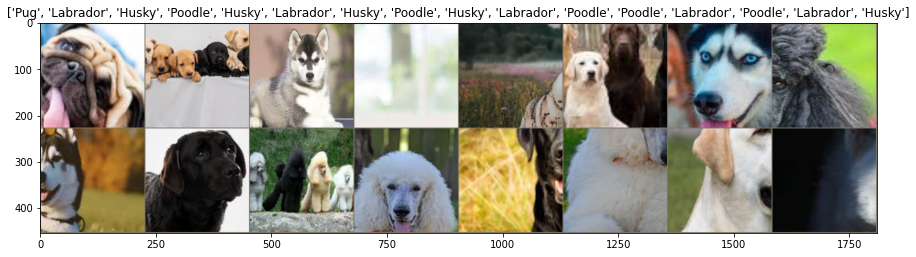

In [9]:
# Iterate over the images we have loaded
inputs, classes = next(iter(dataloaders['train']))

# Select only the first 16 images and classes
inputs = inputs[:16]
classes = classes[:16] 

# Make a grid in order to view the 16 images we have loaded in
out = torchvision.utils.make_grid(inputs)

# Use the functions defined above in order to plot the flower images
imshow(out, title=[dataset_labels[int(class_names[x])-1] for x in classes])

In [10]:
# Here we are defining our training function. This function will loop through the number of epochs and apply set training criteria to our input model
def train_model(model, num_epochs=25):

    # Send model to the device to utilize GPU for faster processing
    model = model.to(device)

    # This is setting our loss function, we want to use an entropy loss in order to measure the accuracy of our model
    criterion = nn.CrossEntropyLoss()

    # Establishes the descent method, we use Stochastic Gradient Descent with a loss ratio of 0.001
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # This is the schedule we will follow for our descent, with each iteration our scheduler will increase in step and we will adjust our optimizer
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() # Set the model into training mode
        running_corrects = 0 # This wil allow us to measure our accuracy
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Resets the optimizer at the begining of each iteration

            outputs = model(inputs) # Save model outputs

            preds = torch.max(outputs, 1)[1] # Set aside our predictions as the most likely label (the label with the highest predicted score)

            running_corrects += torch.sum(preds == labels.data) # Check to see if our predictions were accurate and add to our tally of correct predictions

            loss = criterion(outputs, labels) # Calculate the loss from the model based on our criterion

            loss.backward() # Backwards step-wise optimization

            optimizer.step() # increment the optimizer based on the results

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train'])) # Let's view the results in the console
        
        scheduler.step() # Lastly, we need to increment the scheduler so that in the next iteration we will properly desced towards a minimum loss
    
        ###Val
        # Here we are testing our model on the validation set to ensure that we are producing accurate results
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [11]:
# Read in ResNet-18 model, a residual network model with 18 layers
model = models.resnet18(pretrained=True)

# Set aside the features within the model and perform a linear transformation on those features
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

In [12]:
model = train_model(model, num_epochs=15)

Epoch:  1 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.80
Valid  Acc: 0.99
#######################
Epoch:  2 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.90
Valid  Acc: 0.99
#######################
Epoch:  3 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.90
Valid  Acc: 1.00
#######################
Epoch:  4 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.91
Valid  Acc: 1.00
#######################
Epoch:  5 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.91
Valid  Acc: 0.99
#######################
Epoch:  6 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.93
Valid  Acc: 1.00
#######################
Epoch:  7 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.92
Valid  Acc: 1.00
#######################
Epoch:  8 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.92
Valid  Acc: 1.00
#######################
Epoch:  9 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.94
Valid  Acc: 1.00
#######################
Epoch:  10 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.93
Valid  Acc: 1.00
#######################
Epoch:  11 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.94
Valid  Acc: 1.00
#######################
Epoch:  12 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.93
Valid  Acc: 1.00
#######################
Epoch:  13 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.94
Valid  Acc: 1.00
#######################
Epoch:  14 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.94
Valid  Acc: 1.00
#######################
Epoch:  15 / 15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.94
Valid  Acc: 1.00
#######################


In [13]:
def imshow2(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    fig.set_size_inches(4, 4)
    plt.show()

# Here we are defining our visualization function, this will plot our image, print the prediction, and print the correct label
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow2(inputs.cpu().data[j],title1)

            if index == num_images:
                return

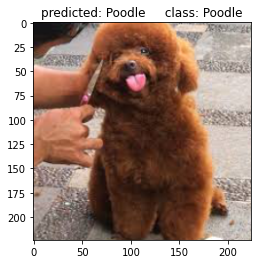

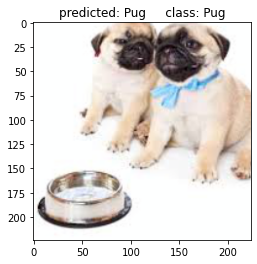

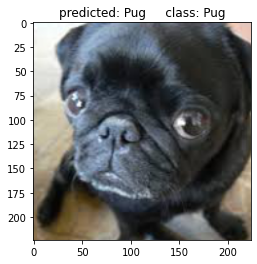

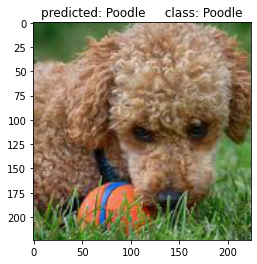

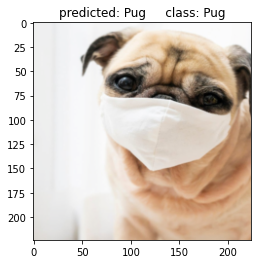

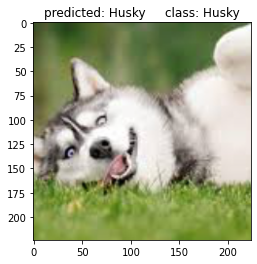

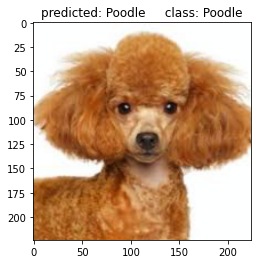

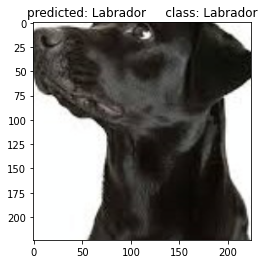

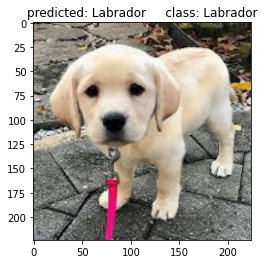

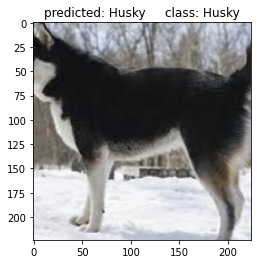

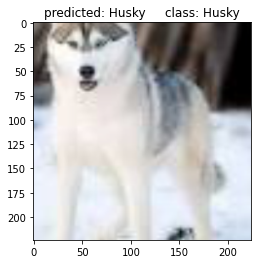

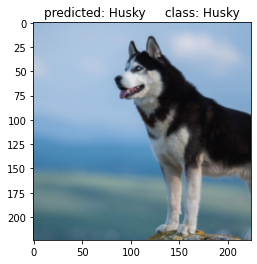

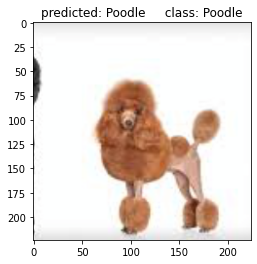

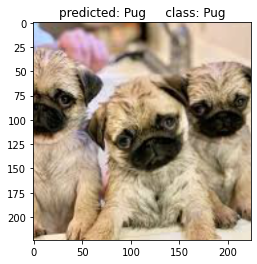

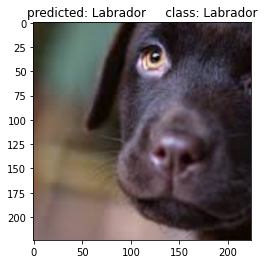

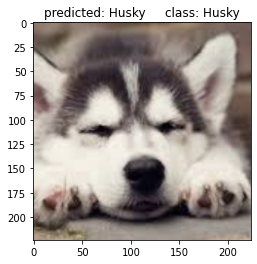

In [17]:
visualize_model(model)

predicted: Labrador


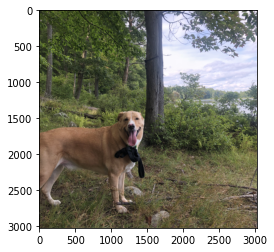

In [24]:
## load in image from drive and apply the model to see if it can produce the correct classification
image = io.imread('/content/drive/MyDrive/Cooper.jpeg')
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)
outputs = model(img)
preds = torch.max(outputs, 1)[1]
print('predicted: ' + dataset_labels[preds])
plt.imshow(image);

predicted: Husky


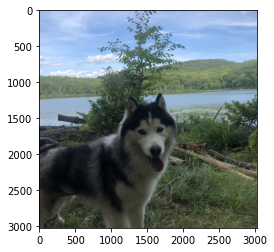

In [23]:
## load in image from drive and apply the model to see if it can produce the correct classification
image = io.imread('/content/drive/MyDrive/Einstein.jpeg')
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)
outputs = model(img)
preds = torch.max(outputs, 1)[1]
print('predicted: ' + dataset_labels[preds])
plt.imshow(image);

In [22]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

In [24]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [25]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [26]:
print("Confusion Matrix : ")
cm

Confusion Matrix : 


array([[118,   0,   0,   0],
       [  0, 120,   0,   1],
       [  0,   0, 117,   0],
       [  0,   0,   0, 115]])

Calculate each of the following:

Accuracy (ACC)
The percentage of correctly identified true and false samples.

True positive (TP)
The number of correctly identified samples. 

True negative (TN)
The number of correctly identified negative samples.
 
False positive (FP)
The number of wrongly identified samples, i.e., a commonly called a "false alarm". 
 
False negative (FN)
The number of wrongly identified negative samples. 

Recall (REC)
This metric is also frequently called sensitivity, probability of detection and true positive rate, and it is the ratio of samples that are correctly identified as positive among all existing positive samples.
 
Precision (PREC)
This metric is also frequently called the positive predictive value, and shows the ratio of samples that are correctly identified as positive.

Specificity (SPEC)
This metric is frequently called the true negative rate, and shows the ratio of negatives that are correctly identified as such.
 
F1 score (F1)
A measure of a test’s accuracy by calculating the harmonic mean of the precision and recall.


In [15]:
from sklearn.metrics import f1_score

cnf_matrix = cm
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Global F1 score using totals
F1 = f1_score(preds.reshape(-1),labels, average = 'micro')

NameError: ignored

In [65]:
print("True positives: ", sum(TP))
print("True negatives: ", sum(TN))
print("False positives: ", sum(FP))
print("False Negatives: ", sum(FN))

True positives:  470.0
True negatives:  1412.0
False positives:  1.0
False Negatives:  1.0


In [28]:
ACC

array([1.        , 0.99787686, 1.        , 0.99787686])

In [29]:
FDR

array([0.        , 0.        , 0.        , 0.00862069])

In [30]:
TPR

array([1.        , 0.99173554, 1.        , 1.        ])

In [31]:
TNR

array([1.        , 1.        , 1.        , 0.99719101])

In [32]:
PPV

array([1.        , 1.        , 1.        , 0.99137931])

In [33]:
NPV

array([1.      , 0.997151, 1.      , 1.      ])

In [34]:
FPR

array([0.        , 0.        , 0.        , 0.00280899])

In [49]:
F1

0.9978768577494692